In [126]:
from google.colab import files
uploaded = files.upload()

Saving stocks.csv to stocks (5).csv


In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'

In [128]:
df = pd.read_csv('stocks.csv',parse_dates=[["YEAR", "MONTH", "DAY"]], index_col="YEAR_MONTH_DAY")
df.index.names = ["DATE"]
df = pd.DataFrame(df.groupby(df.index.strftime('%Y-%m')).sum()['CLOSE'])
df.columns=['Value']

In [129]:
df

,Value
DATE,
2020-01,2920.74
2020-02,2816.66
2020-03,2715.28
2020-04,2904.90
2020-05,2397.48
2020-06,3864.74
2020-07,4308.44
2020-08,4013.97
2020-09,6276.06


Equation for AR model : <br>
![alt text](https://i.stack.imgur.com/cj6yX.png)

In [130]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

  train_size = (int)(0.9 * df_temp.shape[0])

  #Breaking data set into test and training
  df_train = pd.DataFrame(df_temp[0:train_size])
  df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

  df_train_2 = df_train.dropna()
  #X contains the lagged values ,hence we skip the first column
  X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # df_train_2[['Value','Predicted_Values']].plot()

  X_test = df_test.iloc[:,1:].values.reshape(-1,p)
  df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  # df_test[['Value','Predicted_Values']].plot()

  RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of p : ",p)
  return [df_train_2,df_test,theta,intercept,RMSE]

In [131]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  train_size = (int)(0.9 * res.shape[0])

  res_train = pd.DataFrame(res[0:train_size])
  res_test = pd.DataFrame(res[train_size:res.shape[0]])

  res_train_2 = res_train.dropna()
  X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
  y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()

  X_test = res_test.iloc[:,1:].values.reshape(-1,q)
  res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
  res_test[['Residuals','Predicted_Values']].plot()

  from sklearn.metrics import mean_squared_error
  RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

  print("The RMSE is :", RMSE,", Value of q : ",q)
  return [res_train_2,res_test,theta,intercept,RMSE]



In [132]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

<h1>
We break down the ARIMA Model into 3 steps:

1. Making the data stationary by differencing. (I)
2. Fitting an AR model. (AR)
3. Fitting an MA model on the residuals. (MA)
4. Getting Back Original data

</h1>

#Step 1 : Making the data stationary

Different techniques can be used to make the data stationary, used log and differencing. The additional diff(12) is remove the seasonality.

In [133]:
df_testing = pd.DataFrame(np.log(df.Value).diff().diff(12))
adf_check(df_testing.Value.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.070558660873
p-value : 0.256516674813553
Number of Lags Used : 2
Number of Observations Used : 38
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



<Axes: xlabel='DATE'>

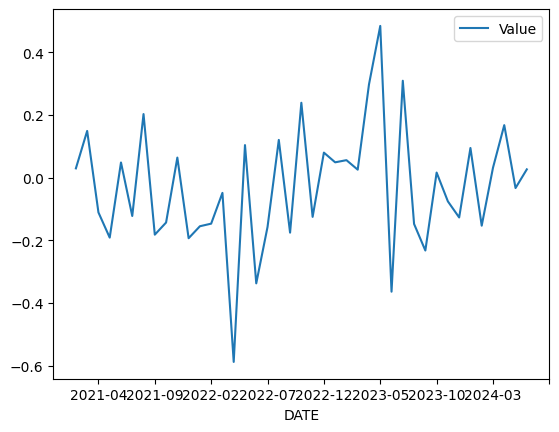

In [134]:
# print(df_testing.to_string())
df_testing.plot()

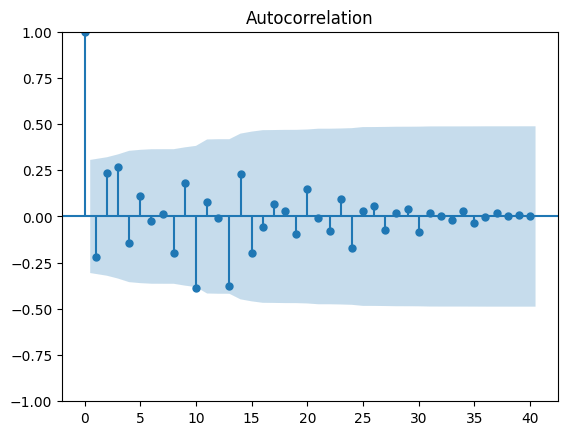

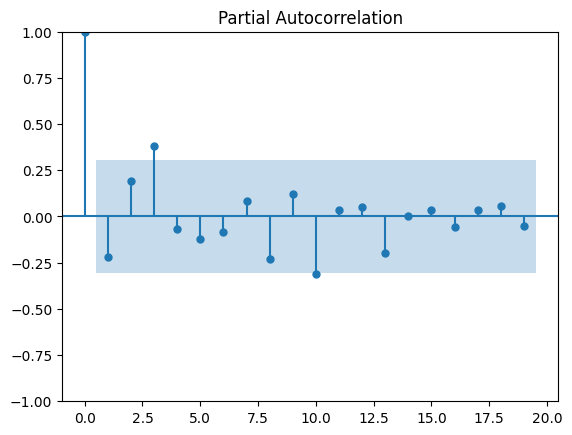

In [135]:
# Calculate the maximum allowable lags
max_lags = min(50, len(df_testing.dropna()) // 2 - 1)

ACF = plot_acf(df_testing.dropna(), lags=min(50, len(df_testing.dropna())-1)) # Adjust lags to available data
PACF = plot_pacf(df_testing.dropna(), lags=max_lags)  # Adjust lags to available data

#Step 2 : Fitting AR Model

We calculate the error on the test-set for each p, and pick the best one.

In [136]:
best_RMSE=100000000000
best_p = -1

for i in range(1,21):
  [df_train,df_test,theta,intercept,RMSE] = AR(i,pd.DataFrame(df_testing.Value))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_p = i

print(best_p)

The RMSE is : 0.11504930894070116 , Value of p :  1
The RMSE is : 0.12106828415936959 , Value of p :  2
The RMSE is : 0.10702681782358724 , Value of p :  3
The RMSE is : 0.10074807333972113 , Value of p :  4
The RMSE is : 0.09460901786159356 , Value of p :  5
The RMSE is : 0.10508843043678905 , Value of p :  6
The RMSE is : 0.1438809624741709 , Value of p :  7
The RMSE is : 0.2148509867571603 , Value of p :  8
The RMSE is : 0.2045778109865606 , Value of p :  9
The RMSE is : 0.3188322789809491 , Value of p :  10
The RMSE is : 0.3429971765034195 , Value of p :  11
The RMSE is : 0.37598068651097954 , Value of p :  12
The RMSE is : 0.3911539660524876 , Value of p :  13
The RMSE is : 0.3633838458246316 , Value of p :  14
The RMSE is : 0.3753477459235215 , Value of p :  15
The RMSE is : 0.4450617047238334 , Value of p :  16
The RMSE is : 0.6522568539398572 , Value of p :  17
The RMSE is : 0.6927711969939409 , Value of p :  18
The RMSE is : 0.6922725396581536 , Value of p :  19
The RMSE is : 

In [137]:
[df_train,df_test,theta,intercept,RMSE] = AR(best_p,pd.DataFrame(df_testing.Value))

The RMSE is : 0.09460901786159356 , Value of p :  5


<Axes: xlabel='DATE'>

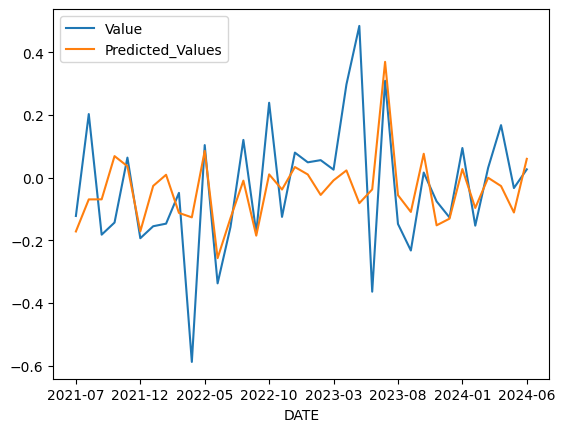

In [138]:
df_c = pd.concat([df_train,df_test])
df_c[['Value','Predicted_Values']].plot()

Generating the residuals for MA

In [139]:
res = pd.DataFrame()
res['Residuals'] = df_c.Value - df_c.Predicted_Values

In [140]:
res

,Residuals
DATE,
2021-07,0.049420
2021-08,0.272193
2021-09,-0.112708
2021-10,-0.211862
2021-11,0.027492
2021-12,-0.021767
2022-01,-0.128682
2022-02,-0.155900
2022-03,0.063982


<Axes: ylabel='Density'>

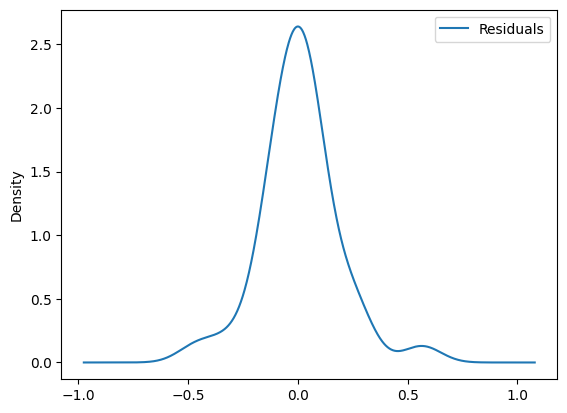

In [141]:
res.plot(kind='kde')

#Step 3 : Fitting MA on Residuals

The RMSE is : 0.10887294339237948 , Value of q :  1
The RMSE is : 0.11631878364643626 , Value of q :  2
The RMSE is : 0.11164269753809944 , Value of q :  3
The RMSE is : 0.11142212336142045 , Value of q :  4
The RMSE is : 0.11548305332848416 , Value of q :  5
The RMSE is : 0.11617865828744803 , Value of q :  6
The RMSE is : 0.1406092997801559 , Value of q :  7
The RMSE is : 0.13322702731737315 , Value of q :  8
The RMSE is : 0.13385786323186152 , Value of q :  9
The RMSE is : 0.23862873451688058 , Value of q :  10
The RMSE is : 0.2633486831168131 , Value of q :  11
The RMSE is : 0.39700034925411654 , Value of q :  12
1


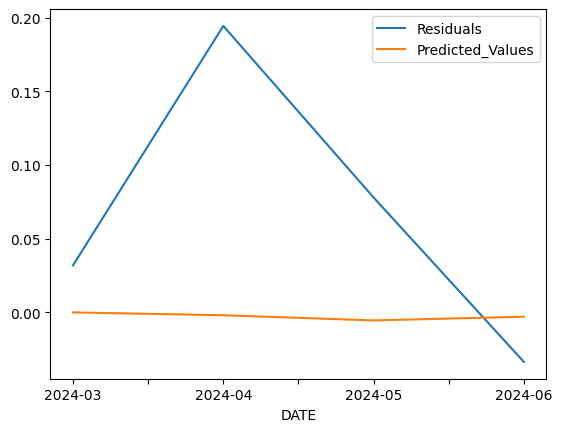

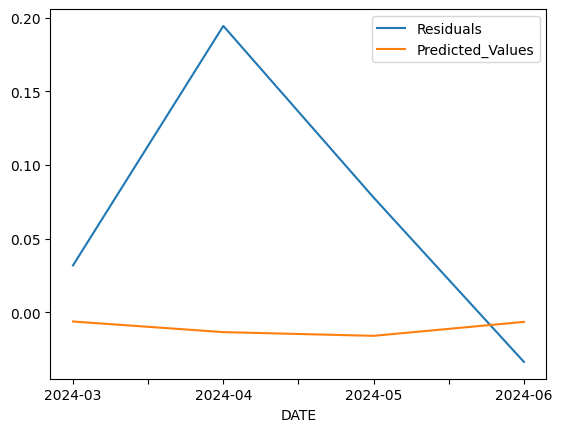

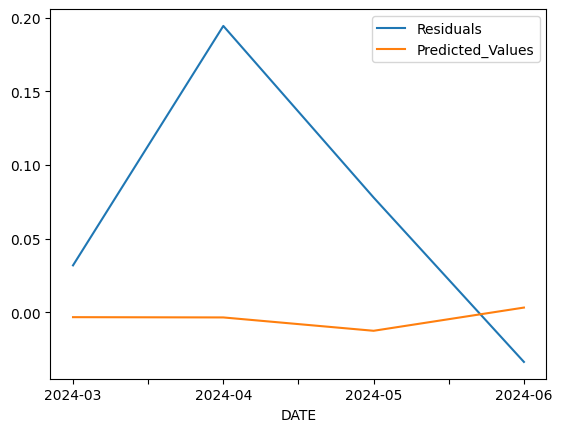

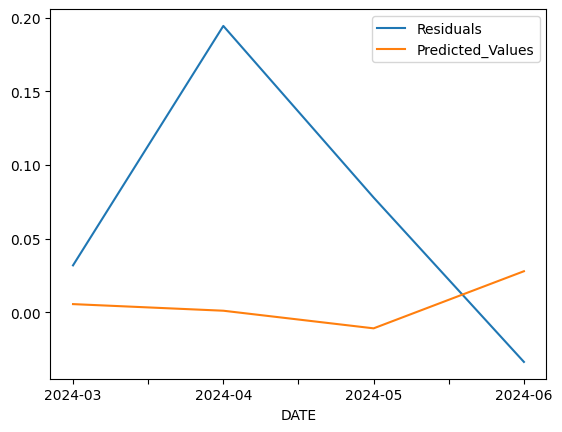

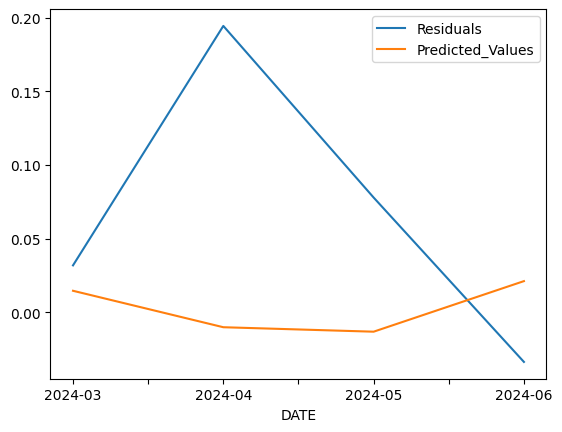

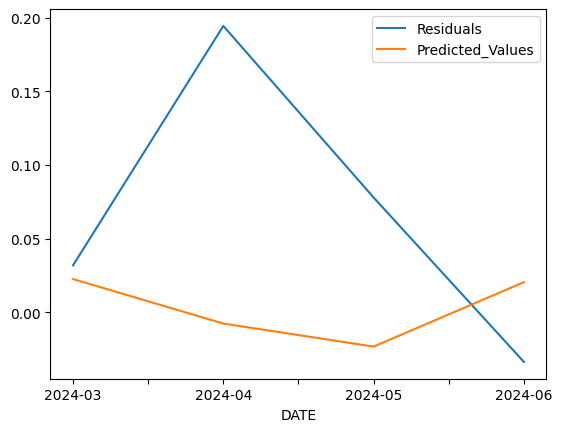

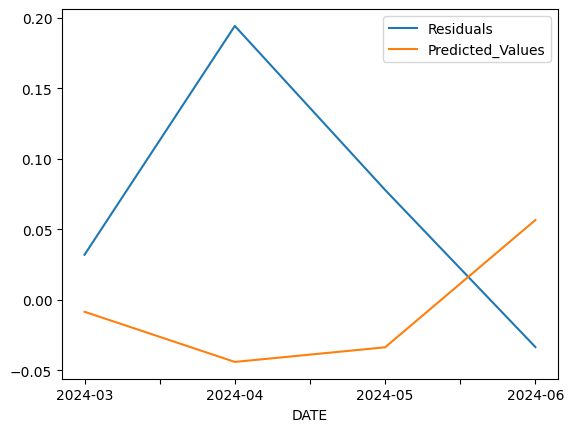

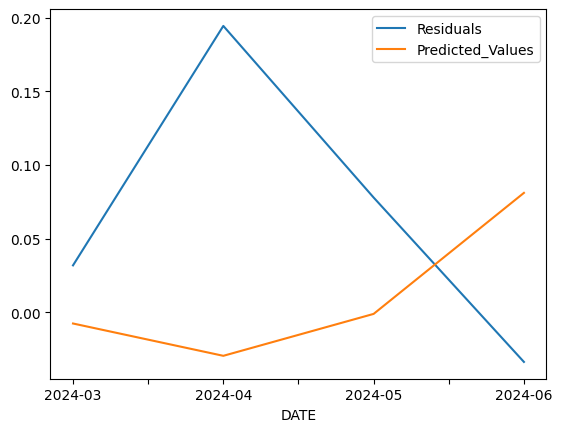

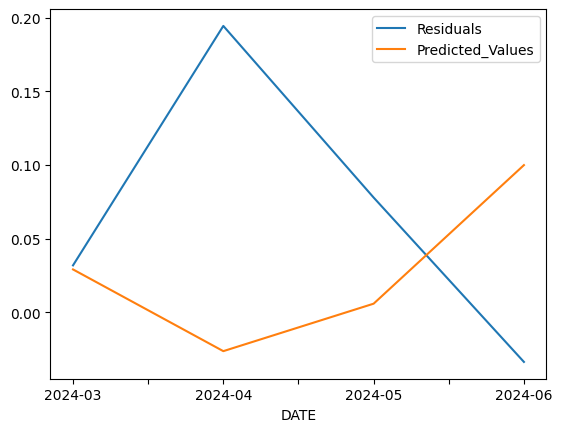

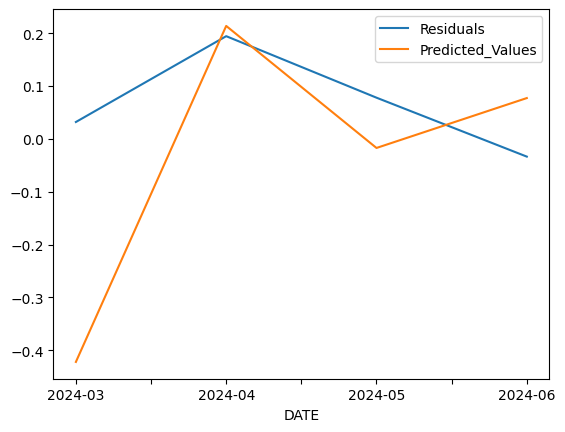

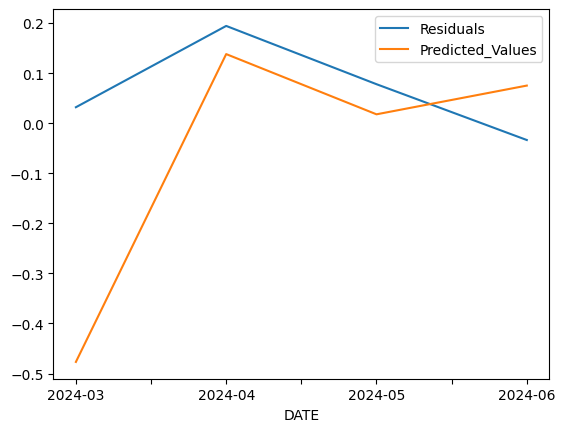

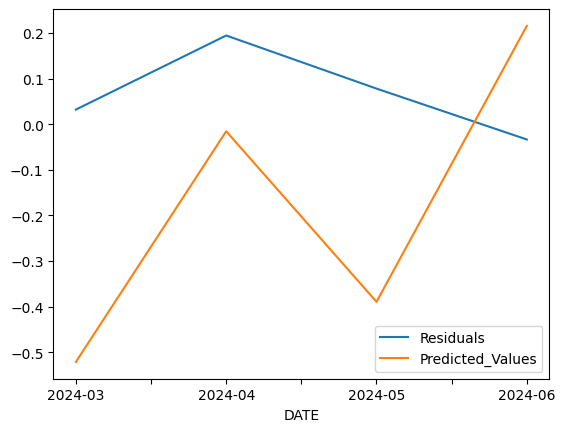

In [142]:
best_RMSE=100000000000
best_q = -1

for i in range(1,13):
  [res_train,res_test,theta,intercept,RMSE] = MA(i,pd.DataFrame(res.Residuals))
  if(RMSE<best_RMSE):
    best_RMSE = RMSE
    best_q = i

print(best_q)

The RMSE is : 0.10887294339237948 , Value of q :  1
[[-0.02164406]]
[-0.00120186]


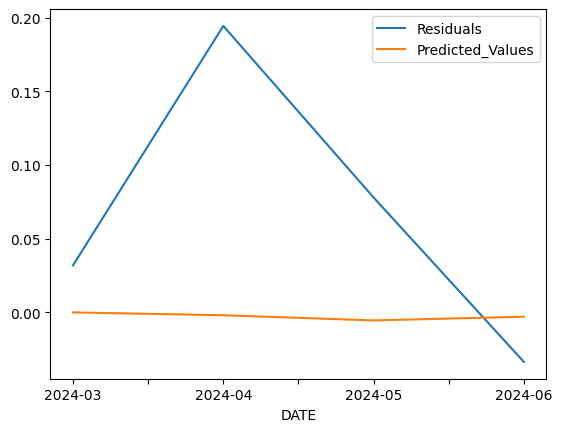

In [143]:
[res_train,res_test,theta,intercept,RMSE] = MA(best_q,pd.DataFrame(res.Residuals))
print(theta)
print(intercept)

In [144]:
res_c = pd.concat([res_train,res_test])

In [145]:
res_c

,Residuals,Shifted_values_1,Predicted_Values
DATE,,,
2021-08,0.272193,0.049420,-0.002272
2021-09,-0.112708,0.272193,-0.007093
2021-10,-0.211862,-0.112708,0.001238
2021-11,0.027492,-0.211862,0.003384
2021-12,-0.021767,0.027492,-0.001797
2022-01,-0.128682,-0.021767,-0.000731
2022-02,-0.155900,-0.128682,0.001583
2022-03,0.063982,-0.155900,0.002172
2022-04,-0.461166,0.063982,-0.002587


In [146]:
df_c.Predicted_Values += res_c.Predicted_Values

<Axes: xlabel='DATE'>

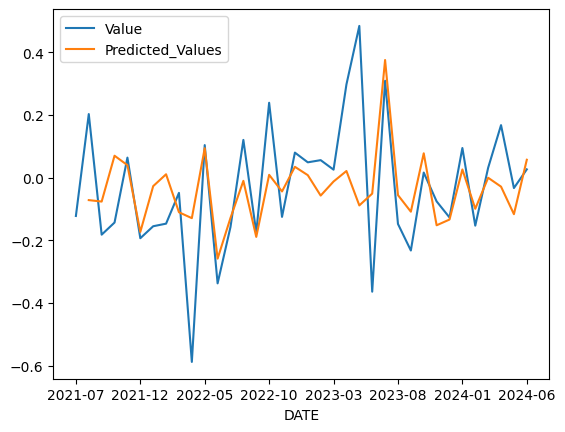

In [147]:
df_c[['Value','Predicted_Values']].plot()

# Step 4 : Getting Back Original data

Reversing the steps performed for differencing, as a check the first column (Value) must be the same after reversing the steps.

In [148]:
# Convert the 'Value' column in 'df' to numeric type if it contains dates
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Extract numeric values from 'Value' column for log transformation
numeric_values = df['Value'][pd.to_numeric(df['Value'], errors='coerce').notna()]

# Use index-based access instead of '.Value'
df_c.Value += np.log(numeric_values).shift(1)
df_c.Value += np.log(numeric_values).diff().shift(12)
df_c.Predicted_Values += np.log(numeric_values).shift(1)
df_c.Predicted_Values += np.log(numeric_values).diff().shift(12)
df_c.Value = np.exp(df_c.Value)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

In [149]:
df_c

,Value,Shifted_values_1,Shifted_values_2,Shifted_values_3,Shifted_values_4,Shifted_values_5,Predicted_Values
DATE,,,,,,,
2021-07,11284.10,0.048404,-0.191302,-0.110939,0.149012,0.029570,NaN
2021-08,12876.39,-0.122271,0.048404,-0.191302,-0.110939,0.149012,9785.781655
2021-09,16784.00,0.202796,-0.122271,0.048404,-0.191302,-0.110939,18653.631417
2021-10,13796.03,-0.181931,0.202796,-0.122271,0.048404,-0.191302,17072.695616
2021-11,17132.55,-0.143212,-0.181931,0.202796,-0.122271,0.048404,16724.455798
2021-12,17434.59,0.063934,-0.143212,-0.181931,0.202796,-0.122271,17786.257880
2022-01,16252.97,-0.193259,0.063934,-0.143212,-0.181931,0.202796,18471.457287
2022-02,13940.52,-0.155053,-0.193259,0.063934,-0.143212,-0.181931,16318.230196
2022-03,14858.18,-0.146760,-0.155053,-0.193259,0.063934,-0.143212,13967.613447


<Axes: xlabel='DATE'>

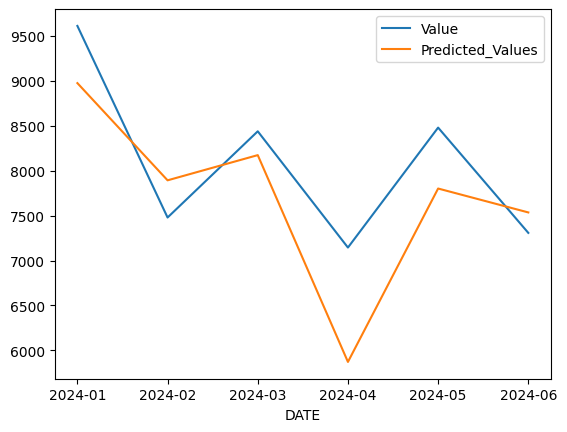

In [150]:
df_c.iloc[30:,:][['Value','Predicted_Values']].plot()